/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Average Training Loss: 0.6344, Training Accuracy: 0.6321
Validation Loss: 0.4519, Validation Accuracy: 0.8200
Epoch 2/10, Average Training Loss: 0.2182, Training Accuracy: 0.9448
Validation Loss: 0.2188, Validation Accuracy: 0.9200
Epoch 3/10, Average Training Loss: 0.0466, Training Accuracy: 0.9883
Validation Loss: 0.3138, Validation Accuracy: 0.9133
Epoch 4/10, Average Training Loss: 0.0058, Training Accuracy: 0.9983
Validation Loss: 0.3561, Validation Accuracy: 0.9333
Epoch 5/10, Average Training Loss: 0.0104, Training Accuracy: 0.9983
Validation Loss: 0.3239, Validation Accuracy: 0.9400
Epoch 6/10, Average Training Loss: 0.0010, Training Accuracy: 1.0000
Validation Loss: 0.3378, Validation Accuracy: 0.9333
Epoch 7/10, Average Training Loss: 0.0008, Training Accuracy: 1.0000
Validation Loss: 0.3492, Validation Accuracy: 0.9333
Epoch 8/10, Average Training Loss: 0.0007, Training Accuracy: 1.0000
Validation Loss: 0.3572, Validation Accuracy: 0.9333
Epoch 9/10, Average Trai

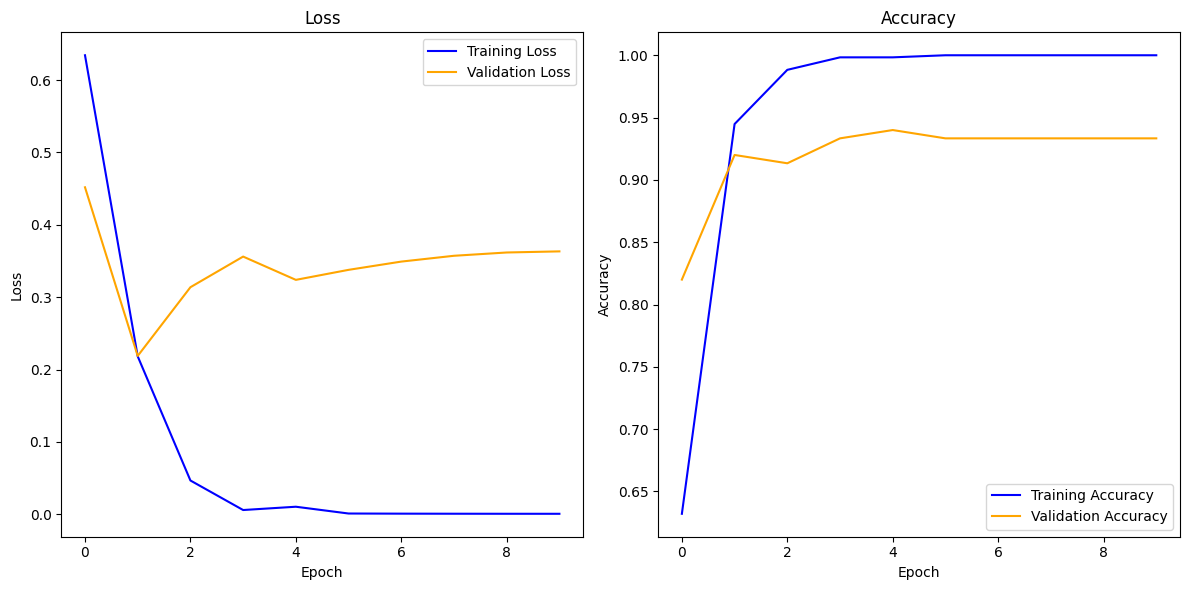

In [ ]:
# Install necessary libraries
!pip install transformers

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("imdb_sentiment.csv")

# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(df['review'], df['sentiment'], stratify=df['sentiment'], test_size=0.2, random_state=42)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize inputs
max_length = 128  # Limit sequence length
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=max_length)

# Create TensorDatasets
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels.tolist()))

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels.tolist()))

# Define DataLoader with reduced batch size
batch_size = 16  # Reduce batch size
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
train_loss_values = []
val_loss_values = []
train_acc_values = []
val_acc_values = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for i, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        total_correct += (predictions == batch[2]).sum().item()
        total_samples += len(batch[2])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = total_correct / total_samples
    train_loss_values.append(avg_train_loss)
    train_acc_values.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_total_loss = 0
    val_total_correct = 0
    val_total_samples = 0
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        with torch.no_grad():
            outputs = model(**inputs)
        val_loss = outputs.loss
        val_total_loss += val_loss.item()
        logits = outputs.logits
        val_predictions = torch.argmax(logits, dim=1)
        val_total_correct += (val_predictions == batch[2]).sum().item()
        val_total_samples += len(batch[2])

    avg_val_loss = val_total_loss / len(test_dataloader)
    val_accuracy = val_total_correct / val_total_samples
    val_loss_values.append(avg_val_loss)
    val_acc_values.append(val_accuracy)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label='Training Accuracy', color='blue')
plt.plot(val_acc_values, label='Validation Accuracy', color='orange')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
